In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
Lx, Ly = 1.0, 1.0
nx, ny = 41, 41

x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

dx = 1.0 / (nx - 1)
dy = 1.0 / (ny - 1)

Re = 10

dt = 1e-4

nt = 9000

In [3]:
u0 = numpy.zeros((ny, nx))
u0[-1, :] = 1
v0 = numpy.zeros((ny, nx))
p0 = numpy.zeros((ny, nx))
b = numpy.zeros_like(p0)

In [4]:
def l2_norm(p, p_ref):
    l2_diff = numpy.sqrt(numpy.sum((p - p_ref)**2))
    l2_ref = numpy.sqrt(numpy.sum(p_ref**2))
    if l2_ref > 1e-12:
        return l2_diff / l2_ref
    return l2_diff

In [5]:
def A(p):
    return ( (-4.0 * p[1:-1, 1:-1] + p[1:-1, :-2] + p[1:-1, 2:] + p[:-2, 1:-1] + p[2:, 1:-1]) / dx**2 )

In [6]:
def conjugate_gradient(p, b, dx, maxiter=20000, rtol=1e-6):
    r = numpy.zeros_like(p)
    Ad = numpy.zeros_like(p)
    diff = rtol + 1
    ite = 0
    r[1:-1, 1:-1] = b[1:-1, 1:-1] - A(p)
    d = r.copy()
    while diff > rtol and ite < maxiter:
        pk = p.copy()
        rk = r.copy()
        Ad[1:-1, 1:-1] = A(d)
        alpha = numpy.sum(r * r) / numpy.sum(d * Ad)
        p = pk + alpha * d
        r = rk - alpha * Ad
        beta = numpy.sum(r * r) / numpy.sum(rk * rk)
        d = r + beta * d
        p[:, 0] = p[:, 1]        #Neumann
        p[:, -1] = p[:, -2]      #Neumann
        p[0, :] = p[1, :]        #Neumann
        p[-1, :] = 0
        diff = l2_norm(p, pk)
        ite += 1
    return p

In [7]:
def fractional_step(u0, v0, Re, nt, p0, b, dx, maxiter=20000, rtol=1e-6):
    u = u0.copy()
    v = v0.copy()
    u_star = u.copy()
    v_star = v.copy()
    pp = p0.copy()
    
    
    for n in range(nt+1):
        u_star[1:-1, 1:-1] = ( u[1:-1, 1:-1] + 
                               dt * (- u[1:-1, 1:-1] * (u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx)
                                     - v[1:-1, 1:-1] * (u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dx)
                                     + ( 1 / (Re * dx**2) ) * (u[1:-1, :-2] - 2 * u[1:-1, 1:-1] + u[1:-1, 2:] +
                                                               u[:-2, 1:-1] - 2 * u[1:-1, 1:-1] + u[2:, 1:-1]) ) )
        
        v_star[1:-1, 1:-1] = ( v[1:-1, 1:-1] + 
                               dt * (- u[1:-1, 1:-1] * (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dx)
                                     - v[1:-1, 1:-1] * (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dx)
                                     + ( 1 / (Re * dx**2) ) * (v[1:-1, :-2] - 2 * v[1:-1, 1:-1] + v[1:-1, 2:] +
                                                               v[:-2, 1:-1] - 2 * v[1:-1, 1:-1] + v[2:, 1:-1]) ) )

        
        
        b[1:-1, 1:-1] = (1/ (2 * dx * dt) ) * (u_star[1:-1, 2:] - u_star[1:-1, :-2] + v_star[2:, 1:-1] - v_star[:-2, 1:-1])
        
        #
        pp = conjugate_gradient(pp, b, dx, maxiter=20000, rtol=1e-6)       
        
        u[1:-1, 1:-1] = u_star[1:-1, 1:-1] - (pp[1:-1, 2:] - pp[1:-1, :-2]) * dt / (2 * dx)
        v[1:-1, 1:-1] = v_star[1:-1, 1:-1] - (pp[2:, 1:-1] - pp[:-2, 1:-1]) * dt / (2 * dx)
        
        u[0, :] = 0
        v[0, :] = 0
        u[:, 0] = 0
        v[:, 0] = 0
        u[:, -1] = 0
        v[:, -1] = 0
        u[-1, :] = 1
        v[-1, :] = 0 
    
    return u, v, pp

In [8]:
u, v, pp = fractional_step(u0, v0, Re, nt, p0, b, dx, maxiter=20000, rtol=1e-6)

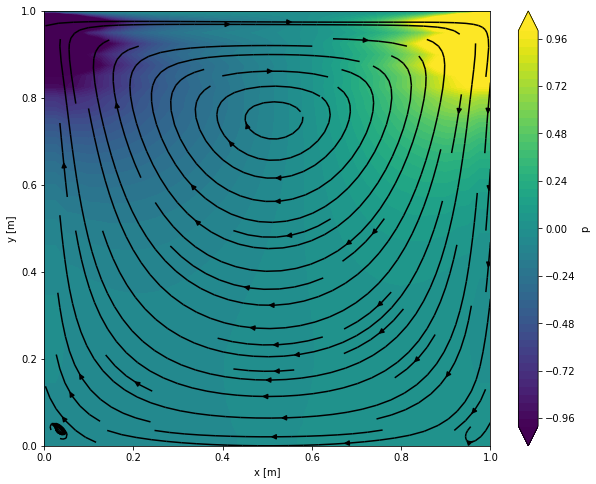

In [9]:
pyplot.figure(figsize=(10.0, 8.0))
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]')
pyplot.xlim(0, 1.0)
pyplot.ylim(0, 1.0)
levels = numpy.linspace(-1.0, 1.0, num=51)
contf = pyplot.contourf(x, y, pp, levels=levels, extend='both')
cbar = pyplot.colorbar(contf)
cbar.set_label('p')
pyplot.streamplot(x, y, u, v, color='black')

In [10]:
DG = (u[1:-1, 2:] - u[1:-1, :-2] + v[2:, 1:-1] - v[:-2, 1:-1]) / (2*dx)
dg = numpy.zeros_like(u0)
dg[1:-1,1:-1]=abs(DG)

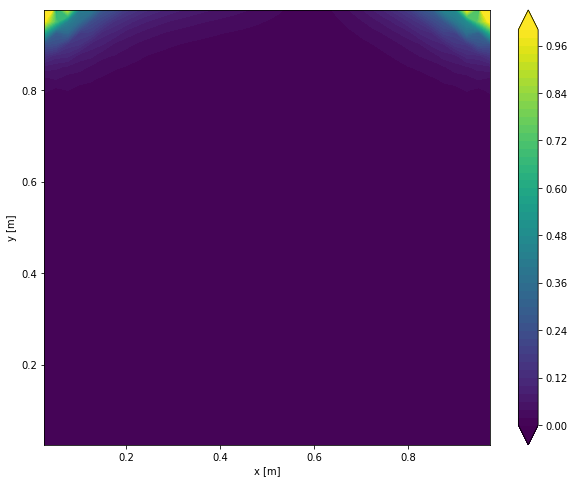

In [11]:
pyplot.figure(figsize=(10.0, 8.0))
pyplot.xlabel('x [m]')
pyplot.ylabel('y [m]')
pyplot.xlim(dx, 1.0-dx)
pyplot.ylim(dx, 1.0-dx)
levels = numpy.linspace(0.0, 1.0, num=51)
contf = pyplot.contourf(x, y, dg, levels=levels, extend='both')
cbar = pyplot.colorbar(contf)

In [12]:
numpy.sqrt(numpy.sum(DG**2))/(39*39)

0.002945601271852639

In [13]:
filepath = 'petibm-cavityRe10.dat'
with open(filepath, 'r') as infile:
    ym, um, xm, vm = numpy.loadtxt(infile,
                                   unpack=True)

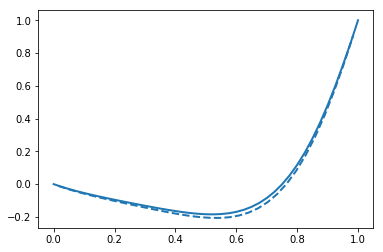

In [14]:
pyplot.plot(ym, um, color='C0', linestyle='--', linewidth=2)
pyplot.plot(y, u[:, 20], color='C0', linestyle='-', linewidth=2)

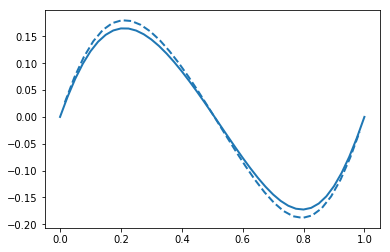

In [15]:
pyplot.plot(xm, vm, color='C0', linestyle='--', linewidth=2)
pyplot.plot(x, v[20, :], color='C0', linestyle='-', linewidth=2)